# Assignment 1: Fisher Implementation
# An overview of our classifier:
This classifier is going to be a one versus all fisher linear discriminant. It's going to classify numbers from 0 to 9 which means it will have 10 classes.

We are going to make our One_vs_all_fisher class, to instantiate this class we will need to pass our training data and training labels. The first two methods in the class are helper methods to clalculate means and covariances.

The first method of interest in this class, which will be called on instantiation, is the train method. This method will take each class individually and calculat the parameters we will need for our classifier method.

After the train method is run, class variabe is made. it's a dictionary that has every class from 0 to 9 as keys and for each one it will hold the following values:
- The optimal weight vector: w
- The bias weight: w0 
- The mean of the projected points belonging to the class: y_mean
- And their standard deviation: y_std

Now once we have made an instance of our classifier, we will be able to use its final method to classify our test data. The classify method takes the training data as its only argument.

# The classifier workflow:
The work flow is going to include projecting the points by dotting with each class wright vector, calculating the Z-score, used here as the normalized distance between the point and the respective class mean, and then assign the label with the lowest Z-score for each point.

After that, we will still have some unclassified point. These are the points that were smaller than w0 for all classes. Since these points will always be "to the left of" or "less than" w0, we can calculate the normalized distance between them and w0 for each class as a fraction of w0. We assign the label of the smallest distance

## Below is a flowchart further breaking down the process.

![](Workflow.png)

In [1]:
import numpy as np


class One_vs_all_fisher:
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    self.classes = np.unique(lbls)
    self.train()

# Function to calculate the mean of the intended class and the mean of other classes
  def m(self, c1, images_c1, images_c2):
      m1= []
      for i in range(images_c1.shape[1]):
          m1.append(np.sum(images_c1[:,i])/images_c1[:,i].shape[0])

      m2=[]
      for i in range(images_c2.shape[1]):
          m2.append(np.sum(images_c2[:,i])/images_c2[:,i].shape[0])
      return np.asarray(m1).reshape(1,-1),  np.asarray(m2).reshape(1,-1)

# Function to calculate the covariance of the intended class and the mean of other classes
  def S(self, c1, images_c1, images_c2, means):
    term1 = images_c1 - means[0]

    term2 = images_c2 - means[1]
    return (term1.T).dot(term1), (term2.T).dot(term2)


  def train(self):
    # Dictionary that will contain W, W0, projected class values mean and standard deviatiom
    self.training_values = {}

    for i in self.classes:
      images_c1 =self.images[self.labels == i,:]
      images_c2 = self.images[self.labels != i,:]
      means = self.m(i, images_c1, images_c2)
      covariances = self.S(i, images_c1, images_c2, means)

      Sw = np.matrix(covariances[0] + covariances[1])
      w = np.linalg.pinv(Sw).dot((means[0]-means[1]).T)
      w0 = float(.5*(means[0]+means[1]).dot(w))

      y_class = np.asarray(np.dot(w.T,images_c1.T)).reshape(-1)
      y_mean = sum(y_class)/len(y_class)
      y_std = np.std(y_class)

      self.training_values[i] = w, w0, y_mean, y_std



  def classify(self, test_images):
    labels = np.empty((test_images.shape[0] ,) , dtype = int)
    zscores = np.empty((test_images.shape[0] ,) , dtype = int)
    y_all = []
    for i in self.classes:
      w = self.training_values[i][0]
      w0 = self.training_values[i][1]
      y_mean = self.training_values[i][2]
      y_std = self.training_values[i][3]
      y = np.asarray(np.dot(w.T,test_images.T)).reshape(-1)
      y_all.append(y)
      for image_index in range(len(y)):
        if labels[image_index] in self.classes:
          zscore = np.absolute((y[image_index] - y_mean)/y_std)
          if zscores[image_index] > zscore:
            labels[image_index] = i
            zscores[image_index] = zscore
        else:
          if y[image_index] > w0:
            zscore = np.absolute((y[image_index] - y_mean)/y_std)
            labels[image_index] = i
            zscores[image_index] = zscore
    for i in range(len(labels)):
      if labels[i] in self.classes:
        continue
      else:
        all_projections = np.asarray([y_all[int(ii)][i] for ii in self.classes])
        all_w0 = np.asarray([self.training_values[int(ii)][1] for ii in self.classes])
        distance = list((all_w0 - all_projections)/all_w0)
        labels[i] = distance.index(min(distance))
    return labels


# Importing our test and training data.

In [2]:
import os
import imageio


home_path = os.getcwd()
path='./Train'
os.chdir(path)
Images=os.listdir()

Images1=sorted(Images, key=lambda t: int(os.path.splitext(t)[0])) # sort them ascendingly
ImagF=np.zeros((2400,784))  # All Images
for i in range(len(Images1)):
    ImagF1=imageio.imread(Images1[i])
    ImagF[i,:]=ImagF1.reshape((1,784))


os.chdir(home_path)
lbls=np.loadtxt("Training Labels.txt")
lbls_T=np.loadtxt("Test Labels.txt")
path='./Test'
os.chdir(path)
Test_Image=os.listdir()
Test_Image.pop()
Test_Image1=sorted(Test_Image, key=lambda t: int(os.path.splitext(t)[0]))
ImagF_T=np.zeros((200,784))
for i in range(len(Test_Image1)):
    Imag=imageio.imread(Test_Image1[i])
    ImagF_T[i,:]=Imag.reshape((1,784))

# The First run of our classifier:
We will train our classifier and test its accuracy by doing a one to one comparison of each predicted label vs the true label

In [3]:
classifier = One_vs_all_fisher(ImagF, lbls)
# Calculate Predicted labels
t = classifier.classify(ImagF_T)


#Calculate Accuracy and Print it
Accuracy = 100*np.sum(t == lbls_T)/len(lbls_T)
print(f"Accuracy of predicted labels = {Accuracy}%")

Accuracy of predicted labels = 74.5%


# Improving the accuracy by manipulating the data:
A quick cursory look at the data will reveal that the numbers are not centered and that there's a varying amount of blank spaces arround the each number. we will work to make the numbers centered in the center of the image, and eliminate as much blank space as possible. 

Eliminating the blank space will reduce the number of features our program has to consider, improving speed and accuracy.

## We are going to introduce two functions:
- center, which crops all the blank space around the number, then pads the number to get the lowest dimension of the image to 28.
- crop, which takes the resulting image from center and crops it down to the intended size

In [4]:
def center(image):
   mask = image>95
   image = image[np.ix_(mask.any(1),mask.any(0))]
   shortest_dimension = min(image.shape)
   compensation = 14 - np.floor((shortest_dimension)//2)
   return np.pad(image, pad_width = int(compensation), mode = 'constant', constant_values = 0)


def crop(images,cropx,cropy):
  no_of_images = images.shape[0]
  images_cropped = np.empty((no_of_images , cropx * cropy) , dtype = int)

  for i in range(no_of_images):
    image = images[i,:].reshape(28,28)
    image = center(image)
    dimensions = image.shape
    startx = (dimensions[1] - cropx)//2
    starty = (dimensions[0]-cropy)//2
    cropped_image = image[starty:starty+cropy:,startx:startx+cropx].reshape(1, cropx * cropy)
    images_cropped[i,:] = cropped_image

  return images_cropped

## Pre-processing of the images:
We are going to use center and crop to crop our images down to the size of 23 x 23 which after down many trails, I found that it produced the best accuracy scores.

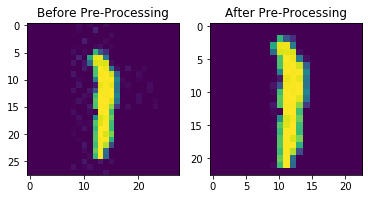

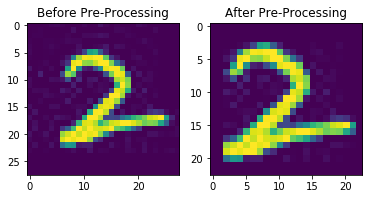

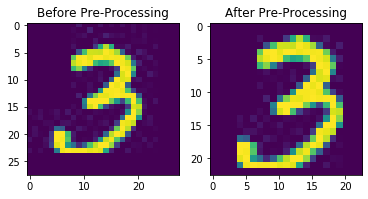

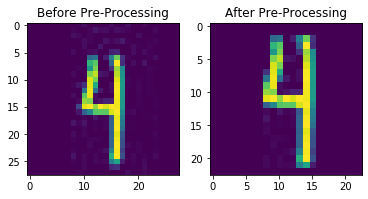

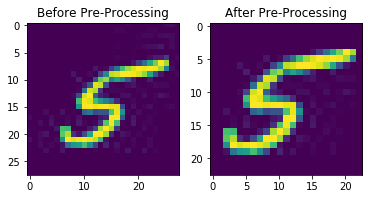

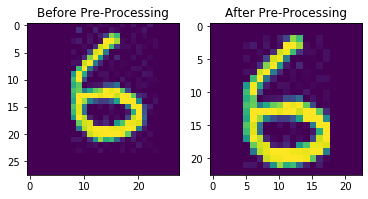

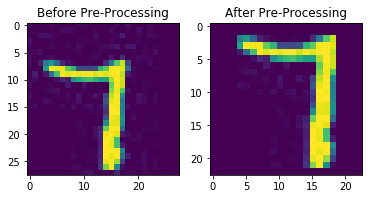

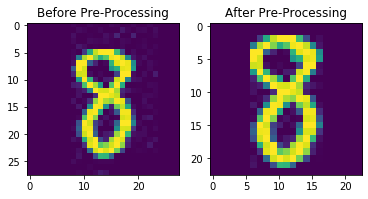

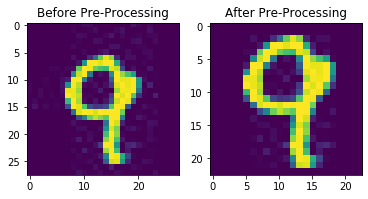

In [5]:
import matplotlib.pylab as plt
ImagF_crop = crop(ImagF,23,23)
ImagF_T_crop = crop(ImagF_T,23,23)

%matplotlib inline

for i in range(1,10):
    axes1 = plt.subplot(1, 2, 1)
    axes1.imshow(ImagF[220+i*240,:].reshape(28,28))
    axes1.set_title('Before Pre-Processing')
    axes2 = plt.subplot(1, 2, 2)
    axes2.imshow(ImagF_crop[220+i*240,:].reshape(23,23))
    axes2.set_title('After Pre-Processing')
    plt.show()


# Runing our classifier on the pre-processed data:
The accuracy improved from 74.5% to 79%!

In [6]:
classifier = One_vs_all_fisher(ImagF_crop, lbls)
t = classifier.classify(ImagF_T_crop)

Accuracy = 100*np.sum(t == lbls_T)/len(lbls_T)
print(f"Accuracy of predicted labels = {Accuracy}% with image 23 x 23")

Accuracy of predicted labels = 79.0% with image 23 x 23


# Confusion matrix and classification report:
We will use scikit learn to produce the confusion matrix

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(lbls_T, t)

print('Confusion Matrix: ')
print(cm)
print('\n')
print('Accuracy Score :',accuracy_score(lbls_T, t))
print('\n')
print('Report : ')
print(classification_report(lbls_T, t))

Confusion Matrix: 
[[19  0  0  0  0  0  1  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  1 18  0  0  0  0  1  0  0]
 [ 0  1  1 16  0  1  0  0  0  1]
 [ 0  1  1  0 14  1  1  0  1  1]
 [ 0  0  0  1  0 16  1  1  1  0]
 [ 0  0  0  0  1  3 15  1  0  0]
 [ 0  1  1  0  0  0  0 16  2  0]
 [ 1  0  0  2  2  1  0  0 13  1]
 [ 1  1  0  1  2  0  0  0  4 11]]


Accuracy Score : 0.79


Report : 
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        20
         1.0       0.80      1.00      0.89        20
         2.0       0.86      0.90      0.88        20
         3.0       0.80      0.80      0.80        20
         4.0       0.74      0.70      0.72        20
         5.0       0.73      0.80      0.76        20
         6.0       0.83      0.75      0.79        20
         7.0       0.84      0.80      0.82        20
         8.0       0.62      0.65      0.63        20
         9.0       0.79      0.55      0.65        20

    accuracy      

# Plotting the confusion matrix

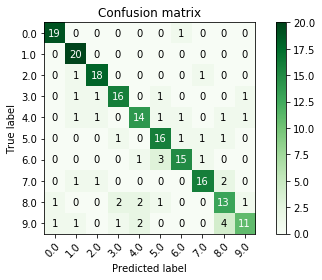

In [8]:
title = 'Confusion matrix'

cmap = plt.cm.Greens
classes = np.unique(lbls_T)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

ax.margins(y = 5)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

os.chdir(home_path)
fig.savefig('Confusion Matrix.png')